# Retrieve Stock Data and Save to DF

In [1]:
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [2]:
try:
    ticker='SPY'
    input_dir = os.getcwd()
    output_file = os.path.join(input_dir, ticker + '.csv')
    df = get_stock(ticker, start_date='2000-01-01', end_date='2025-07-08', 
               s_window=14, l_window=50)
    df.to_csv(output_file, index=False)
    print('wrote ' + str(len(df)) + ' lines to file: ' + output_file)
except Exception as e:
    print(e)
    print('failed to get Yahoo stock data for ticker: ', ticker)

[*********************100%***********************]  1 of 1 completed
C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1516439336.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)


read  6415  lines of data for ticker:  SPY
wrote 6415 lines to file: c:\Users\aksha\Documents\BU_RISE\Final_Project\stock-data\SPY.csv


In [3]:
#psuedocode
'''
1. create ATR column
2. create SD column
3. build LSTM columnn
4. split into train and test
5. train lstm on training data for ATR and test
6. train lstm on training data for SD and test
7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)
'''

'\n1. create ATR column\n2. create SD column\n3. build LSTM columnn\n4. split into train and test\n5. train lstm on training data for ATR and test\n6. train lstm on training data for SD and test\n7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)\n'

In [4]:
 #.xs returns a cross section; selects only values within the SPY indexes at level=1
df_n= df.xs('SPY',axis=1,level=1)
#cleaned up data

In [5]:
# import math
# #challenge of how to deal with missing values in time series data
# #choose sliding window of length=N (could be 20?) N_lstmtraining>N_atrslidingwindow
# def atr_func(d):
#     running = 0
#     for i in range(len(d)):
#         high = d.loc[i,"High"]
#         low = d.loc[i,"Low"]
#         if i==0:
#             running += high-low
#             continue
#         if i>0:
#             y_close = d.loc[i,"Close"]
        
#         TR = max(high-low,max(math.abs(high-y_close),math.abs(low-y_close)))
#         running+=TR
#     return running/len(d)

# df_n['ATR'] = df_n.rolling(window=14).apply(atr_func)
# df_n

In [6]:
#define ATR columns
high = df_n["High"]
low = df_n["Low"]
close = df_n["Close"]

prev_close = close.shift(1)


tr = pd.concat([
    high - low,
    (high - prev_close).abs(),
    (low - prev_close).abs()
], axis=1).max(axis=1)

df_n["ATR"] = tr.rolling(7).mean()

C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\4206602609.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()


In [7]:
import numpy as np

log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
df_n["SD_Log_Close"] = log_diff.rolling(7).std()
df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()
#xlb, xle, 
df_n

C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1671279891.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["SD_Log_Close"] = log_diff.rolling(7).std()
C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1671279891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1671279891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Price,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close,ATR_normalized,SD_normalized
Date,,,,,,,,,,
2000-01-03,148.25,148.25,143.88,145.44,8164300,92.14,NaN,NaN,NaN,NaN
2000-01-04,143.53,144.06,139.64,139.75,8089800,88.54,NaN,NaN,NaN,NaN
2000-01-05,139.94,141.53,137.25,140.00,12177900,88.70,NaN,NaN,NaN,NaN
2000-01-06,139.62,141.50,137.75,137.75,6227200,87.27,NaN,NaN,NaN,NaN
2000-01-07,140.31,145.75,140.06,145.75,8066500,92.34,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,617.38,619.22,615.04,617.85,92502500,617.85,5.868571,0.005666,1.151276,-0.589089
2025-07-01,616.36,618.83,615.52,617.65,70030100,617.65,5.398571,0.004345,0.965648,-0.766251
2025-07-02,617.24,620.49,616.61,620.45,66510400,620.45,4.717143,0.003906,0.696516,-0.825029


In [8]:
import numpy as np
from scipy.stats import linregress

def slope(x):
    idx = np.arange(len(x))
    return linregress(idx, x).slope

df_n['atr_slope_7'] = df_n['ATR'].rolling(window=7).apply(slope, raw=True)
df_n['stock_slope'] = df_n['Open'].rolling(window=7).apply(slope, raw=True)

C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1641309427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['atr_slope_7'] = df_n['ATR'].rolling(window=7).apply(slope, raw=True)
C:\Users\aksha\AppData\Local\Temp\ipykernel_6496\1641309427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['stock_slope'] = df_n['Open'].rolling(window=7).apply(slope, raw=True)


In [9]:
#drop na values (first 6 rows)
df_n = df_n.dropna()
df_n = df_n.reset_index()
df_n = df_n.reset_index()


In [10]:
df_n["index"] = df_n["index"]%7

In [11]:
df_n

Price,index,Date,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close,ATR_normalized,SD_normalized,atr_slope_7,stock_slope
0,0,2000-01-20,146.97,146.97,143.81,144.75,5800100,91.71,2.370000,0.012651,-0.230495,0.347628,-0.368776,0.206786
1,1,2000-01-21,145.50,145.50,144.06,144.44,6244800,91.51,2.182857,0.011798,-0.304408,0.233226,-0.324388,0.232500
2,2,2000-01-24,145.66,145.84,139.41,140.34,7896900,88.92,2.857143,0.015872,-0.038097,0.779455,-0.182704,0.112143
3,3,2000-01-25,140.52,141.94,139.00,141.94,9942500,89.93,2.892857,0.015525,-0.023991,0.732997,-0.058980,-0.614286
4,4,2000-01-26,141.00,141.55,140.09,140.81,5158100,89.21,2.804286,0.013730,-0.058973,0.492267,0.042857,-0.853929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6398,0,2025-06-30,617.38,619.22,615.04,617.85,92502500,617.85,5.868571,0.005666,1.151276,-0.589089,-0.111990,3.476429
6399,1,2025-07-01,616.36,618.83,615.52,617.65,70030100,617.65,5.398571,0.004345,0.965648,-0.766251,-0.221327,3.393929
6400,2,2025-07-02,617.24,620.49,616.61,620.45,66510400,620.45,4.717143,0.003906,0.696516,-0.825029,-0.318673,2.286429
6401,3,2025-07-03,622.45,626.28,622.43,625.34,51065800,625.34,4.450000,0.003185,0.591007,-0.921698,-0.308265,2.271429


In [12]:
# df_n["Delta_Days"] = [(df_n.loc[i,"Date"] - df_n.loc[0,"Date"]).days for i in range(len(df_n))]
# #save clean data
# df_n.to_csv("Clean_Data.csv")

In [13]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [14]:
#define PDE loss
def PDE_loss(v_hat,):
    return 0
    #use torch.autograd to get PDE loss

In [ ]:
# def tt_split(df_n,vol_metric,scaler:StandardScaler):
#     train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
#     X_train_no_met = train[["index","Open","Close","High","Low"]].to_numpy()

#     y_train = train[vol_metric].to_numpy()
#     y_train = scaler.fit_transform(y_train.reshape(-1,1))
    
#     X_train = np.concatenate((X_train_no_met,y_train),axis=1)
#     print("X_train shape:", X_train.shape)
#     test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
#     X_test_no_met = test[["index","Open","Close","High","Low"]].to_numpy()    
#     y_test = test[vol_metric].to_numpy()
#     y_test = scaler.transform(y_test.reshape(-1,1))

#     X_test = np.concatenate((X_test_no_met,y_test),axis = 1)
#     return X_train,y_train,X_test,y_test


#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [16]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 6] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
#X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [17]:
from torch.utils.data import DataLoader, TensorDataset

def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
#loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [18]:
# #training loop
# model = NN_LSTM(input_size=5,output_size=1)
# epochs = 100
# optim = torch.optim.Adam(params = model.parameters())
# crit = MSELoss()
# losses = []
# losses_test = []

# for i in range(epochs):
#     running_loss = 0
#     for x_window,y_atr in loader:
#         #print("Running")
#         input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
#         out = model(input)
#         #print(y_atr.shape)
#         #print(out,y_atr)
#         #break
#         loss = crit(out,y_atr)
#         running_loss+=loss.item()
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#             # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
#     #break
#     running_loss/=(len(loader))
#     #print(f"Training Loss: {running_loss}")
#     losses.append(running_loss)

#     with torch.no_grad():
#         testing_loss = 0
#         for x_window_test,y_atr_test in loader_test:
#             out_test = model(x_window_test.permute(1,0,2))
#             #print(y_atr_test.shape)
#             loss = crit(out_test,y_atr_test)
#             testing_loss+=loss.item()
#         losses_test.append(testing_loss/(len(loader_test)))
    


In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.lineplot(x=[i for i in range(len(losses))],y=losses)
# plt.title("Training Loss of LSTM (ATR_normalized) across 60 epochs")

In [20]:
# sns.lineplot(losses_test)
# plt.title("Testing Loss of LSTM (ATR_normalized) across 60 epochs")

In [21]:
# X_train_sd,y_train_sd,X_test_sd,y_test_sd = tt_split(df_n,vol_metric="SD_normalized")
# X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd = make_seq(X_train_sd,y_train_sd,X_test_sd,y_test_sd)
# loader_sd,loader_test_sd = create_loaders(X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd)

In [22]:
# #training loop
# model_sd = NN_LSTM(input_size=5,output_size=1)
# epochs = 100
# optim = torch.optim.Adam(params = model_sd.parameters())
# crit = MSELoss()
# losses = []
# losses_test = []

# for i in range(epochs):
#     running_loss = 0
#     for x_window,y_sd in loader_sd:
#         #print("Running")
#         input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
#         out = model_sd(input)
#         #print(y_sd.shape)
#         loss = crit(out,y_sd)
#         running_loss+=loss.item()
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#             # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
#     running_loss/=(len(loader_sd))
#     #print(f"Training Loss: {running_loss}")
#     losses.append(running_loss)

#     with torch.no_grad():
#         testing_loss = 0
#         for x_window_test,y_sd_test in loader_test_sd:
#             out_test = model_sd(x_window_test.permute(1,0,2))
#             #print(y_sd_test.shape)
#             loss = crit(out_test,y_sd_test)
#             testing_loss+=loss.item()
#         losses_test.append(testing_loss/(len(loader_test_sd)))


In [23]:
# sns.lineplot(losses)
# plt.title("Training Loss of LSTM (SD__normalized) across 60 epochs")

In [24]:
# sns.lineplot(losses_test)
# plt.title("Testing Loss of LSTM (SD_normalized) across 60 epochs")

In [25]:
#use past atrs
#try transformations of atr log(atr)

In [ ]:
def get_cleaned_df(ticker,start,end):
    df = get_stock(ticker,start_date=start,end_date=end,s_window=14,l_window=50)
    df_n= df.xs(ticker,axis=1,level=1)
    
        #define ATR columns
    high = df_n["High"]
    low = df_n["Low"]
    close = df_n["Close"]

    prev_close = close.shift(1)


    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df_n["ATR"] = tr.rolling(7).mean()
    
    log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
    df_n["SD_Log_Close"] = log_diff.rolling(7).std()
    #df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
    #df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()

    df_n = df_n.dropna()
    df_n = df_n.reset_index().reset_index()
    df_n["index"] = df_n.index%7
    return df_n

In [27]:
def pipeline(ticker,start,end,metric):
    df_n = get_cleaned_df(ticker,start,end)
    #print(df_n)

    X_train,y_train,X_test,y_test = tt_split(df_n, metric)

    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=6,output_size=1)
    epochs = 100
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    losses = []
    losses_test = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            loss = crit(out,y_atr)
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        #print(f"Training Loss: {running_loss}")
        losses.append(running_loss)

        with torch.no_grad():
            testing_loss = 0
            for x_window_test,y_atr_test in loader_test:
                out_test = model(x_window_test.permute(1,0,2))
                #print(y_atr_test.shape)
                loss = crit(out_test,y_atr_test)
                testing_loss+=loss.item()
            losses_test.append(testing_loss/(len(loader_test)))

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title(f"Training Loss of LSTM ({metric}) across 60 epochs for {ticker}")
    plt.show()

    sns.lineplot(losses_test)
    plt.title(f"Testing Loss of LSTM ({metric}) across 60 epochs for {ticker}")
    plt.show()

    return min(losses),min(losses_test)

    

In [28]:
start = "2000-01-01"
end = "2025-07-14"
#pipeline("SPY",start,end,metric="ATR_normalized")

In [29]:
#pipeline("XLP",start,end,metric="SD_normalized")
import pandas as pd

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
# metrics = ["ATR_normalized","SD_normalized"]
# df = pd.DataFrame({"etf":[],"metric":[],"train_loss":[],"test_loss":[]})
# for etf in etfs[:2]:
#     for metric in metrics:
#         train_loss_atr, test_loss_atr = pipeline(etf,start,end,metric=metric)
#         df.loc[len(df)] = [etf,metric,train_loss_atr,test_loss_atr]


In [32]:
import math
    

In [41]:

def run_sim(df_n):
    money = 200
    shares = 0
    for i in range(len(df_n['Open'])):
        price = money/df_n['Open'].loc[i]
        if (df_n['atr_slope_7'].loc[i] < 0) & (df_n['stock_slope'].loc[i] > 0):
            max_shares = math.floor(price)
            shares += max_shares
            money -= (max_shares * price)
        elif (df_n['atr_slope_7'].loc[i] > 0) & (df_n['stock_slope'].loc[i] < 0):
            money+= (shares*price)
            shares = 0
    money+= (shares*price)
    shares = 0

    return money

#run_sim(df_n)


#df_n

In [39]:

def run_sim_2(data:pd.DataFrame,lstm_model,money = 1000,T=30,R=400):
    shares = 0
    for i in range(30,len(data)):
        past_window = data.iloc[i-T:i+1] #end is exclusive
        past_window_atr = past_window["ATR"]
        qr1, qr3, median = np.quantile(past_window_atr,.25),np.quantile(past_window_atr,.75),np.quantile(past_window_atr,.5)
        iqr = qr3-qr1
        lower = median - 1.5*iqr
        upper = median + 1.5*iqr


        input = np.array(past_window[["index","Open","Close","Low","High","ATR_normalized"]])
        input = input.reshape((len(input),1,len(input[0])))
        atr_next_norm = lstm_model(input)
        atr_next = atr_next_norm*data["ATR"].std() + data["ATR"].mean() #this method has limitations as we won't know pop mean and std IRL
        #denormalize the input
        
        if atr_next>upper:
            #sell
            #should we check if the close price is greater than what we bought for?
            money+=shares*data.loc[i,"Close"]
            shares=0

        elif atr_next<lower:
            #buy
            shares_to_buy = R/atr_next
            money-=data.loc[i,"Open"]*shares_to_buy
            shares+=shares_to_buy
    return money,shares

        



    

In [71]:
import numpy as np
import pandas as pd

def backtest_atr_strategy(data: pd.DataFrame,
                          lstm_model,
                          scaler:StandardScaler,
                          T: int = 30,
                          R: float = 1000.0):
    """
    Backtest a simple ATR‑based mean‑reversion strategy:
      - Predict next ATR with an LSTM
      - If predicted ATR is unusually high → go flat (sell)
      - If unusually low → go long
    Assumes 'data' has columns ['Open','High','Low','Close','ATR'].
    'scaler' is a fitted StandardScaler on the train-period ATR.
    """
    cash = 0.0
    shares = 0.0

    # Precompute rolling IQR thresholds on ATR over T bars
    # (we’ll compute quantiles on‑the‑fly inside the loop)
    for i in range(T, len(data)-1):
        window_atr = data['ATR'].iloc[i-T:i]
        q1 = window_atr.quantile(0.25)
        q3 = window_atr.quantile(0.75)
        med = window_atr.quantile(0.50)
        iqr = q3 - q1
        lower = med - 1.5 * iqr
        upper = med + 1.5 * iqr

        # Prepare model input: last T bars of OHLC + normalized ATR
        X = data[['index','Open','High','Low','Close']].iloc[i-T:i].copy()
        X['ATR_norm'] = scaler.transform(data[['ATR']].iloc[i-T:i])  # shape (T,1)
        # reshape to (1, T, features)
        print(X)
        model_in = X.values.reshape(1, T, X.shape[1])
        # Predict next normalized ATR, then denormalize
        atr_next_norm = lstm_model(model_in).item()
        atr_next = scaler.inverse_transform([[atr_next_norm]])[0,0]

        # Next bar’s prices
        open_next  = data['Open'].iloc[i+1]
        close_next = data['Close'].iloc[i+1]

        # Entry/exit signals
        if atr_next > upper and shares > 0:
            # Sell all
            cash += shares * close_next
            shares = 0.0

        elif atr_next < lower:
            # Buy: risk R = shares * ATR_next ⇒ shares = R / ATR_next
            target_shares = R / atr_next
            # adjust cash & position
            delta = target_shares - shares
            cash -= delta * open_next
            shares = target_shares

    # At end, mark-to-market at last close
    final_value = cash + shares * data['Close'].iloc[-1]
    return final_value, cash, shares


In [74]:
def get_trained_model(df,scaler):
    metric = "ATR"
    X_train,y_train,X_test,y_test = tt_split(df, metric,scaler)

    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=6,output_size=1)
    epochs = 100
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    losses = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            loss = crit(out,y_atr)
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        #print(f"Training Loss: {running_loss}")
        losses.append(running_loss)

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title(f"Training Loss of LSTM ({metric}) across 60 epochs for {ticker}")
    plt.show()
    return model
    

In [36]:
import torch
from torch.nn import *
import torch.functional as F

In [ ]:
def tests(ticker,start,end):
    vol_scaler = StandardScaler()
    df = get_cleaned_df(ticker,start,end)
    model = get_trained_model(df,vol_scaler)
    ini_money = 1000
    #money,shares = run_sim(df,model,money=ini_money)
    final,cash,shares = backtest_atr_strategy(df,model,scaler=vol_scaler)
    print("Initial money: ",ini_money)
    print("Final money: ",money)
    print("Final shares: ",shares)
    

In [67]:
df = get_cleaned_df(ticker,start,end)

[*********************100%***********************]  1 of 1 completed


read  6419  lines of data for ticker:  SPY


X_train shape: (5130, 6)


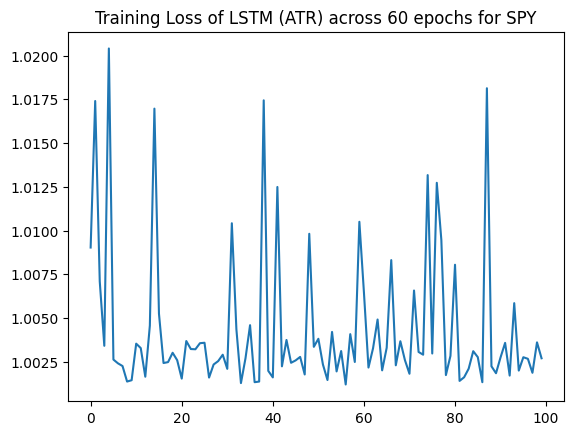

In [ ]:
vol_scaler = StandardScaler()
model = get_trained_model(df,vol_scaler)

In [72]:
ini_money = 1000
    #money,shares = run_sim(df,model,money=ini_money)
final,cash,shares = backtest_atr_strategy(df,model,scaler=vol_scaler)
print("Initial money: ",ini_money)
print("Final money: ",money)
print("Final shares: ",shares)

Price  index    Open    High     Low   Close  ATR_norm
0          0  144.59  144.59  142.88  143.06  1.179089
1          1  144.47  145.75  143.28  145.00  0.898165
2          2  146.53  147.47  145.97  146.97  0.734668
3          3  145.34  146.62  145.19  145.81  0.556719
4          4  145.31  147.00  145.00  147.00  0.014743
5          5  146.97  146.97  143.81  144.75  0.133074
6          6  145.50  145.50  144.06  144.44  0.014743
7          0  145.66  145.84  139.41  140.34  0.441098
8          1  140.52  141.94  139.00  141.94  0.463680
9          2  141.00  141.55  140.09  140.81  0.407676
10         3  141.84  142.22  138.12  140.25  0.617240
11         4  139.44  140.06  135.53  135.88  0.862936
12         5  135.81  139.67  135.00  139.56  0.996624
13         6  139.75  141.69  138.53  140.94  1.151990
14         0  141.28  142.25  140.38  141.06  0.740088
15         1  140.88  143.25  140.00  143.19  0.768090
16         2  143.19  144.00  142.12  142.59  0.770800
17        

TypeError: 'NoneType' object is not callable